In [1]:
import sys, os, time
import numpy as np
%matplotlib notebook
#%matplotlib tk
import matplotlib.pyplot as plt
from yaml import load, dump
import networkx as nx
from scipy.spatial.distance import pdist, squareform

import torch
from torch import nn

In [2]:
borders = load(open('config/borders.yml', 'r'))
tiles = load(open('config/tiles.yml', 'r'))
print(len(tiles), len(borders))

136 349


In [8]:
names = list(tiles.keys())

In [9]:
order = dict(zip(names, np.arange(len(tiles))))

In [10]:
M = np.zeros((len(tiles), len(tiles)))
for b in borders:
    i,j = order[b['tile1']], order[b['tile2']]
    M[i,j] = 1
    M[j,i] = 1
M.sum()

694.0

In [11]:
map_pos = load(open('config/map_pos.yml', 'r'))
tile_rgbs = load(open('config/tile_rgbs.yml', 'r'))
len(map_pos), len(tile_rgbs)

(136, 36)

In [12]:
H, W = 2200, 3400

In [86]:
x = np.array([map_pos[k]['x'] for k in names]) / W
y = 1 - np.array([map_pos[k]['y'] for k in names]) / H
x.shape, y.shape

((136,), (136,))

In [87]:
def get_border_lines(pos):
    lines = []
    for b in borders:
        x1, y1 = pos[order[b['tile1']]]
        x2, y2 = pos[order[b['tile2']]]
        lines.append([[x1,x2],[y1,y2]])
        #plt.plot([x1,x2],[y1,y2],ls='-', color='k')
    return np.array(lines)

<IPython.core.display.Javascript object>


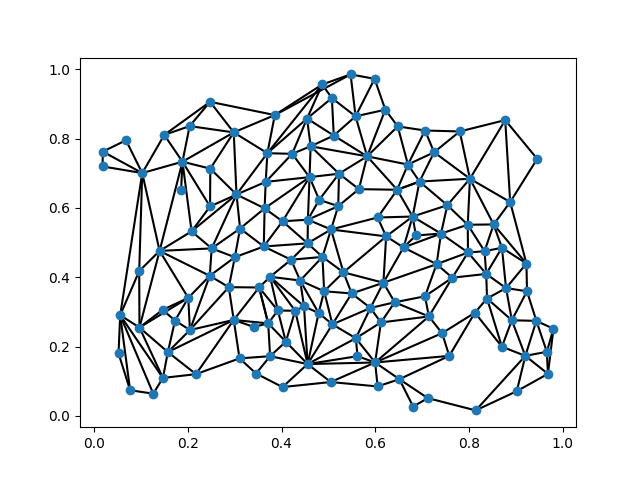

In [88]:
plt.figure()

blines = get_border_lines(np.stack([x,y],-1))
for bl in blines:
    plt.plot(*bl,ls='-', color='k')
    
plt.plot(x,y, ls='', marker='o')

In [13]:
dists[:5,:5]

NameError: name 'dists' is not defined

In [89]:
dists = pdist(np.stack([x,y]).T)
#dists = pdist(new)
D = squareform(dists)
dists.shape, D.shape

((9180,), (136, 136))

In [90]:
adj = squareform(M)
M.shape, adj.shape

((136, 136), (9180,))

In [91]:
edges = dists[adj==1]
edges.shape

(347,)

In [92]:
edges.mean(), edges.std()

(0.0937294943519805, 0.04354664117329082)

<IPython.core.display.Javascript object>


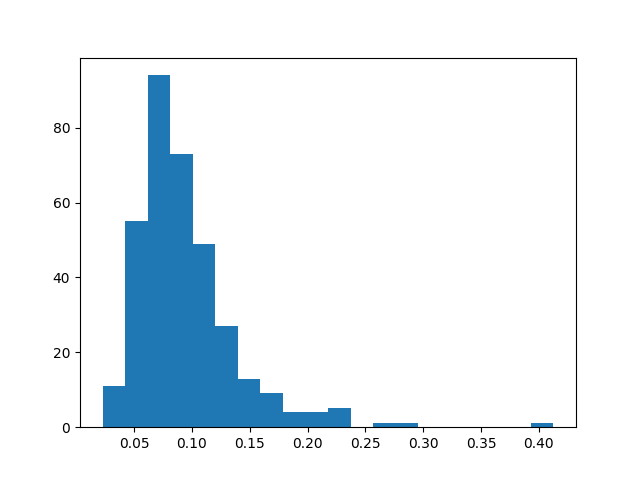

(array([11., 55., 94., 73., 49., 27., 13.,  9.,  4.,  4.,  5.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.02272243, 0.0422209 , 0.06171937, 0.08121784, 0.10071631,
        0.12021477, 0.13971324, 0.15921171, 0.17871018, 0.19820865,
        0.21770712, 0.23720559, 0.25670406, 0.27620253, 0.295701  ,
        0.31519947, 0.33469794, 0.35419641, 0.37369487, 0.39319334,
        0.41269181]),
 <a list of 20 Patch objects>)

In [93]:
plt.figure()
plt.hist(edges, bins=20)

In [126]:
X, Y = torch.from_numpy(x.copy()), torch.from_numpy(y.copy())

In [205]:
sel = torch.from_numpy(M).triu().byte()
sel.sum(), sel.shape

(tensor(347), torch.Size([136, 136]))

In [128]:
points = torch.stack([X,Y],-1).float()
#points.requires_grad = True

In [143]:
new = points.numpy()

In [233]:
points = torch.from_numpy(new)
for i in range(1):
    points.requires_grad = True
    points.grad = None
    points.shape
    d = points.unsqueeze(0) - points.unsqueeze(1) + 1e-16 # N x N x 2
    d = d.pow(2).sum(-1).sqrt() # N x N
    #print(d.shape)
    #print(d)
    all_dists = (1/d).triu(1)
    #print(all_dists.mean())
    edges = d[sel]
    #print(edges)
    L = all_dists.mean()  #+ 5*(edges**2).mean() #+ .1* edges.std() #- 0.1 * all_dists.mean()
    L.backward()
    std = L.item()
    delta = points.grad
    mag=(delta.pow(2).sum().sqrt().item())
    points.requires_grad = False
    points.sub_(0.5 * delta)
    
    print('{:.3f} {:.3f} - {:.3f} {:.3f} {:.3f} {:.3f}'.format(std, mag, 
            points[:,0].min().item(), points[:,0].max().item(), 
            points[:,1].min().item(), points[:,1].max().item()))

0.956 0.088 - -0.491 1.437 -0.447 1.355


In [234]:
new = points.detach().numpy()

<IPython.core.display.Javascript object>


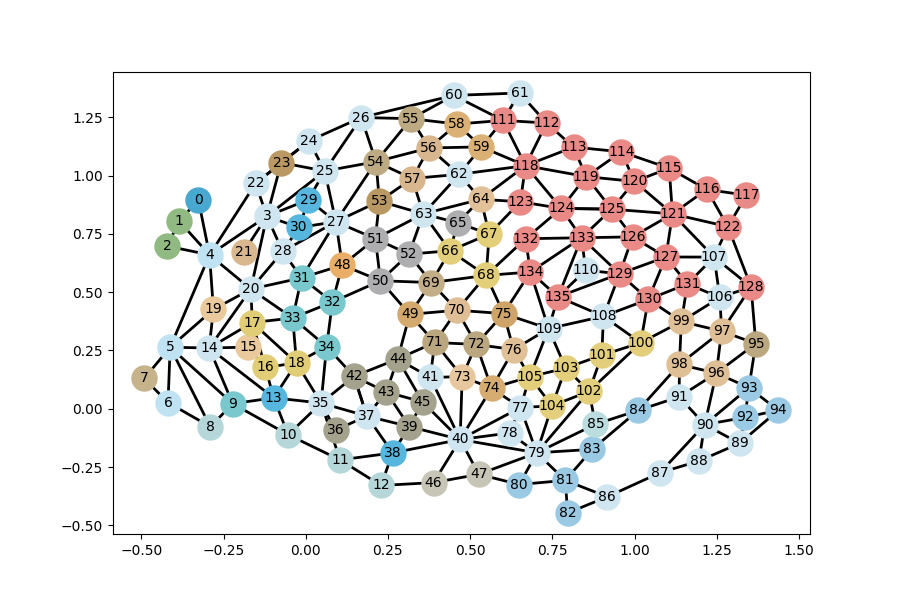

In [235]:
plt.figure(figsize=(9,6))

blines = get_border_lines(new)
for bl in blines:
    plt.plot(*bl,ls='-', color='k', lw=2)
for i, (name, pos) in enumerate(zip(names, new)):
    t = None
    if tiles[name]['type'] == 'sea':
        t = 'Sea'
    elif tiles[name]['type'] == 'ocean':
        t = 'Ocean'
    else:
        t = tiles[name]['alligence']
    t = tile_rgbs[t]
    t = t[0]/255, t[1]/255, t[2]/255
    
    plt.plot([pos[0]], [pos[1]], ls='', marker='o', ms=18, color=t)
    plt.text(*pos, str(i), ha='center', va='center')
#np.save('manual_map_pos1.npy', new)

In [231]:
msel = [17]
print(new[msel])
new[msel] = np.array([-161, 376])/1000

[[-0.1381006   0.30388522]]


In [140]:
names[19]

'Azores'

In [236]:
edges.mean()

tensor(0.1649, grad_fn=<MeanBackward1>)

In [489]:
x = torch.randn(10,3)
x.requires_grad = True
d = torch.nn.functional.pairwise_distance(x,x)
#d = x.pow(2).sum(-1).sqrt().mean()
d

tensor([1.7321e-06, 1.7321e-06, 1.7321e-06, 1.7321e-06, 1.7321e-06, 1.7321e-06,
        1.7321e-06, 1.7321e-06, 1.7321e-06, 1.7321e-06],
       grad_fn=<NormBackward1>)

In [490]:
d.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

In [491]:
x.grad

In [488]:
torch.nn.functional.pairwise_distance?

torch.Size([136, 2])

In [266]:

x

tensor(0.1370, grad_fn=<StdBackward0>)

In [267]:

#points.grad

tensor(0.1475)
tensor(0.0184) tensor(0.9749) tensor(0.0184) tensor(0.9841)


In [16]:
borders[:1]

[{'tile1': 'Ottawa', 'tile2': 'North Atlantic Ocean', 'type': 'coast'}]

In [17]:
G = nx.Graph()

In [18]:
G.add_edges_from((b['tile1'], b['tile2'], {'type':b['type']}) for b in borders)

In [19]:
G.add_nodes_from((k, v) for k,v in tiles.items())

In [20]:
len(G)

136

In [23]:
G['Ottawa']

AtlasView({'North Atlantic Ocean': {'type': 'coast'}, 'New York': {'type': 'forest'}})